In [3]:
import coinmetrics
import numpy as np
import datetime as dt
import pandas as pd
import time
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from pca import pca
from sklearn import preprocessing
from scipy import stats
from scipy.cluster import hierarchy

plt.rcParams["figure.figsize"] = (20,10)

In [35]:
cm = coinmetrics.Community()
moneda = 'dcr'
available_data_types = cm.get_available_data_types_for_asset(moneda)

metrica = "AdrActCnt,BlkCnt,BlkSizeByte,BlkSizeMeanByte,CapRealUSD,CapMrktCurUSD,DiffMean,FeeMeanNtv,\
FeeMeanUSD,FeeMedNtv,FeeMedUSD,FeeTotNtv,FeeTotUSD,\
NVTAdj,NVTAdj90,PriceBTC,PriceUSD,ROI1yr,ROI30d,SplyCur,SplyExpFut10yrCMBI,SplyFF,TxCnt,TxTfrCnt,TxTfrValAdjNtv,\
TxTfrValAdjUSD,TxTfrValMeanNtv,TxTfrValMeanUSD,TxTfrValMedNtv,TxTfrValMedUSD,TxTfrValNtv,TxTfrValUSD,VtyDayRet180d,\
VtyDayRet30d,VtyDayRet60d"

begin_timestamp = "2009-01-01"
end_timestamp = '2020-11-28'
asset_data = cm.get_asset_data_for_time_range(moneda, metrica ,begin_timestamp, end_timestamp)

In [36]:
start_time = time.time()
db = coinmetrics.cm_to_pandas(asset_data)
db.index = np.arange(len(db))
db = db.interpolate(method='polynomial', order=2)
end_time = time.time()
print("Segundos", end_time - start_time)

Segundos 0.13454914093017578


In [37]:
for name in db.columns:
    db[name] = db[name].fillna(0)    

In [38]:
Q1 = db.quantile(0.25)
Q3 = db.quantile(0.75)
IQR = Q3 - Q1

db = db[~((db < (Q1 - 1.5 * IQR)) |(db > (Q3 + 1.5 * IQR))).any(axis=1)]

In [39]:
df = pd.DataFrame(db.values)
df.columns = db.columns

In [40]:
from sklearn.covariance import EmpiricalCovariance, MinCovDet

def m_detectOutliers(data, extreme=False):
    robust_cov = MinCovDet().fit(data)
    m = robust_cov.mahalanobis(data)
    # one popular way to specify the threshold
    me = np.mean(m)
    t = 3. * me if extreme else 2. * me
    outliers = []
    for i in range(len(m)):
        if m[i] > t:
            outliers.append(i)  # index of the outlier
    return np.array(outliers)

df_wo = df.drop(m_detectOutliers(df, extreme = False))

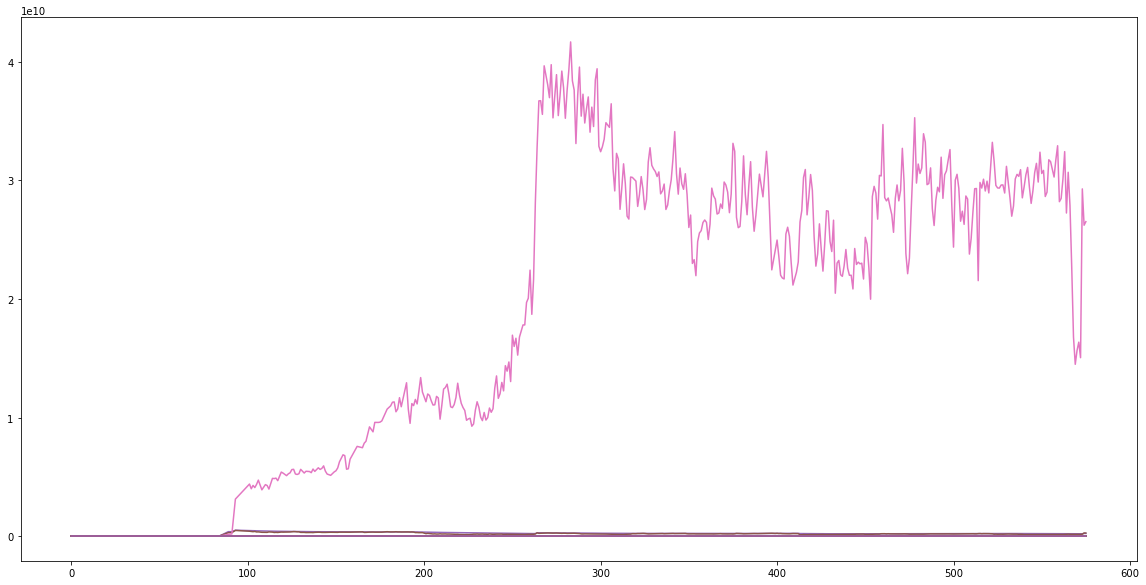

In [41]:
plt.plot(df_wo)
plt.show()

In [42]:
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
import warnings
warnings.filterwarnings('ignore')

In [44]:
X = df_wo[['AdrActCnt','BlkCnt','BlkSizeByte','BlkSizeMeanByte','CapMrktCurUSD','CapRealUSD','DiffMean','FeeMeanNtv','FeeMeanUSD','FeeMedNtv','FeeMedUSD','FeeTotNtv','FeeTotUSD','NVTAdj','NVTAdj90','PriceBTC','ROI1yr','ROI30d','SplyCur','SplyExpFut10yrCMBI','SplyFF','TxCnt','TxTfrCnt','TxTfrValAdjNtv','TxTfrValAdjUSD','TxTfrValMeanNtv','TxTfrValMeanUSD','TxTfrValMedNtv','TxTfrValMedUSD','TxTfrValNtv','TxTfrValUSD','VtyDayRet180d','VtyDayRet30d','VtyDayRet60d']]
y = df_wo['PriceUSD']

X_train, X_test, y_train, y_test = train_test_split(X, y.values.reshape(-1,1), train_size   = 0.8, random_state = 1234, shuffle = True)

In [45]:
X_train = sm.add_constant(X_train, prepend=True)
modelo = sm.OLS(endog=y_train, exog=X_train,)
modelo = modelo.fit()
print(modelo.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.999
Model:                            OLS   Adj. R-squared:                  0.999
Method:                 Least Squares   F-statistic:                 1.291e+04
Date:                Tue, 01 Dec 2020   Prob (F-statistic):               0.00
Time:                        03:14:01   Log-Likelihood:                -121.80
No. Observations:                 413   AIC:                             309.6
Df Residuals:                     380   BIC:                             442.4
Df Model:                          32                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                  2.9923      1

## Eliminamos las variables con p-value < 0.05 ya que no aportan de forma significativa al modelo

## Total **variables restantes 23**

In [46]:
df_regresion_wo = df_wo.drop(['BlkSizeByte', 'BlkCnt','BlkSizeMeanByte','DiffMean','FeeMeanNtv','FeeTotUSD','NVTAdj','NVTAdj90','PriceBTC','TxCnt','TxTfrValAdjNtv','TxTfrValAdjUSD','VtyDayRet60d'], axis=1)

In [47]:
#x = df_wo.values
x = df_regresion_wo.values
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
df = pd.DataFrame(x_scaled)
#df.columns = df_wo.columns
df.columns = df_regresion_wo.columns

In [48]:
model = pca()
# Fit transform
out = model.fit_transform(df)

[pca] >Processing dataframe..
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [22] columns of the input data.
[pca] >Fitting using PCA..
[pca] >Computing loadings and PCs..
[pca] >Computing explained variance..
[pca] >Number of components is [6] that covers the [95.00%] explained variance.
[pca] >Outlier detection using Hotelling T2 test with alpha=[0.05] and n_components=[5]
[pca] >Outlier detection using SPE/DmodX with n_std=[2]


In [49]:
print(out['topfeat'])

      PC             feature   loading  type
0    PC1           FeeMedNtv  0.370934  best
1    PC2           FeeMedUSD  0.408999  best
2    PC3      TxTfrValMedUSD -0.447498  best
3    PC4        VtyDayRet30d  0.707734  best
4    PC5              ROI30d  0.446243  best
5    PC6              ROI30d  0.690984  best
6    PC7        VtyDayRet30d  0.634383  best
7    PC8      TxTfrValMedUSD -0.593399  best
8    PC9              ROI1yr  0.573189  best
9   PC10          FeeMeanUSD  0.401247  best
10  PC11           FeeTotNtv -0.574796  best
11  PC12      TxTfrValMedNtv  0.616206  best
12  PC13           FeeMedNtv  0.689781  best
13  PC14     TxTfrValMeanNtv  0.450158  best
14  PC15         TxTfrValNtv -0.426455  best
15  PC16     TxTfrValMeanUSD -0.569907  best
16  PC17            TxTfrCnt -0.668786  best
17  PC18     TxTfrValMeanUSD -0.482796  best
18  PC19         TxTfrValNtv -0.535494  best
19  PC20            PriceUSD  0.744366  best
20  PC21              SplyFF  0.814637  best
21  PC22  

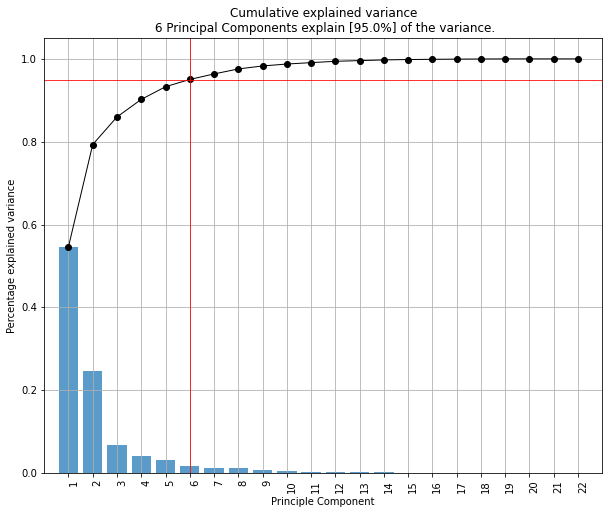

(<Figure size 720x576 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f07c4d66520>)

<Figure size 1440x720 with 0 Axes>

In [50]:
model.plot()

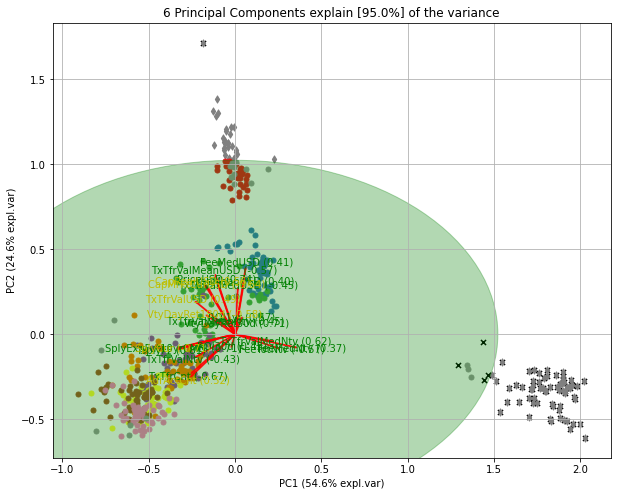

(<Figure size 720x576 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f07c5782dc0>)

In [51]:
model.biplot(legend=False, SPE=True, hotellingt2=True, label = False)

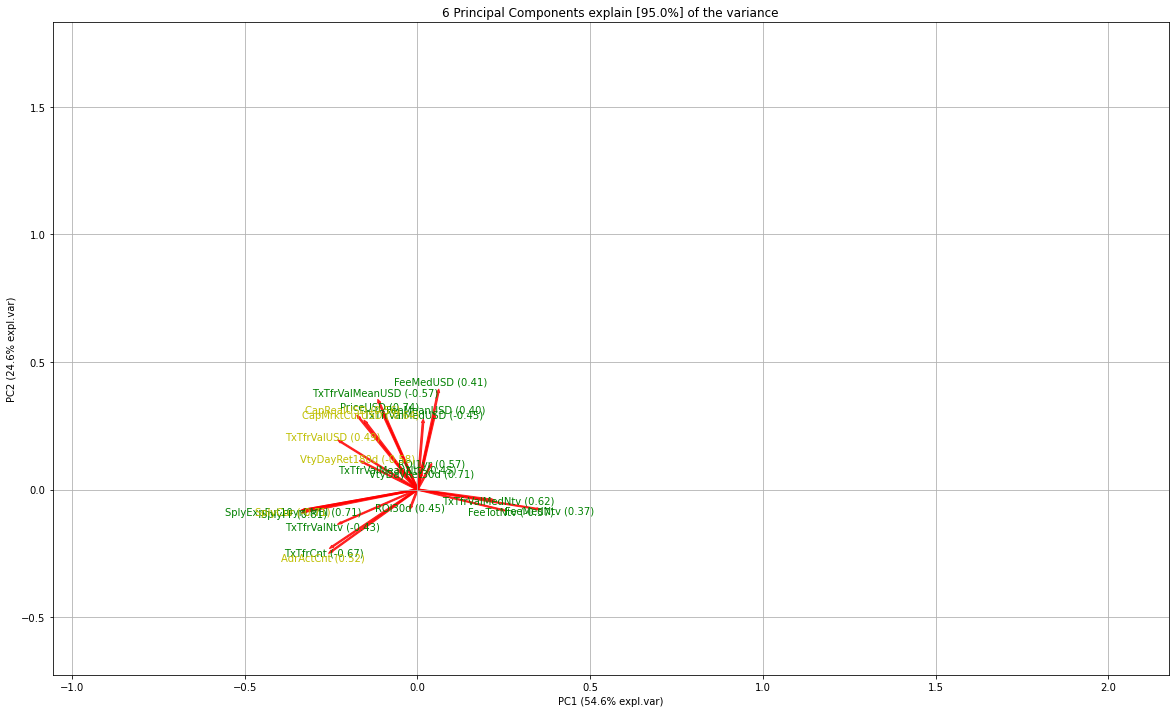

(<Figure size 1440x864 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f07b1ec9c10>)

In [52]:
model.biplot(cmap=None, label=False, legend=False,figsize=(20,12),visible=True)

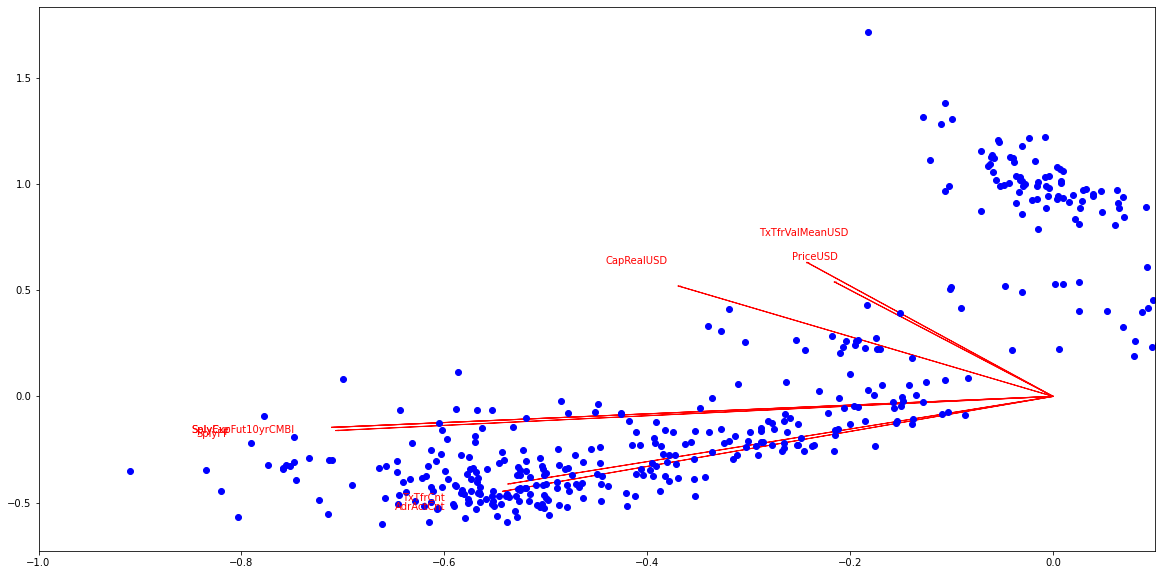

array(['AdrActCnt', 'CapRealUSD', 'PriceUSD', 'SplyCur',
       'SplyExpFut10yrCMBI', 'SplyFF', 'TxTfrCnt', 'TxTfrValMeanUSD'],
      dtype=object)

In [58]:
from sklearn.decomposition import PCA

n = len(df.columns)

pca = PCA(n_components = n)
pca.fit(df)
xvector = pca.components_[0]
yvector = pca.components_[1]
xs = pca.transform(df)[:,0]
ys = pca.transform(df)[:,1]

#print(df.columns.values[7]) #vector priceUSD
#print(xvector[14])
plt.xlim(-1,0.1)
lim = np.sqrt(xvector[7]**2 + yvector[7]**2)
feat = []

for i in range(len(xvector)):
    if(np.sqrt(xvector[i]**2 + yvector[i]**2) >= lim and np.sign(xvector[i]) == np.sign(xvector[7])):
        plt.arrow(0, 0, xvector[i]*max(xs), yvector[i]*max(ys),
                  color='r', width=0.0005, head_width=0.0025)
        plt.text(xvector[i]*max(xs)*1.2, yvector[i]*max(ys)*1.2,
                 list(df.columns.values)[i], color='r')
        feat.append(i)

for i in range(len(xs)):
    plt.plot(xs[i], ys[i], 'bo')
    #plt.text(xs[i]*1.2, ys[i]*1.2, list(df.index)[i], color='b')

plt.show()
df.columns.values[feat]

## Eliminamos las variables que tienen una norma menor al vector PriceUSD y con distinta dirección

## Total de **variables restantes 3**

In [59]:
df_red = df[df.columns.values[feat]].copy()
df_red = df_red.drop(['AdrActCnt','SplyCur','SplyExpFut10yrCMBI','SplyFF','TxTfrCnt'],axis =1)

In [60]:
#Con 29 variables

import dcor
# Create the distance method using distance_correlation
distcorr = lambda column1, column2: dcor.distance_correlation(column1, column2) 
# Apply the distance method pairwise to every column
rslt = df_red.apply(lambda col1: df_regresion_wo.apply(lambda col2: distcorr(col1, col2)))

pd.options.display.float_format = '{:,.2f}'.format
rslt

,CapRealUSD,PriceUSD,TxTfrValMeanUSD
AdrActCnt,0.62,0.52,0.57
CapRealUSD,1.00,0.93,0.86
CapMrktCurUSD,0.93,0.97,0.85
FeeMeanUSD,0.66,0.78,0.63
FeeMedNtv,0.89,0.72,0.68
FeeMedUSD,0.71,0.80,0.69
FeeTotNtv,0.86,0.69,0.65
PriceUSD,0.93,1.00,0.89
ROI1yr,0.52,0.59,0.44
ROI30d,0.26,0.12,0.15


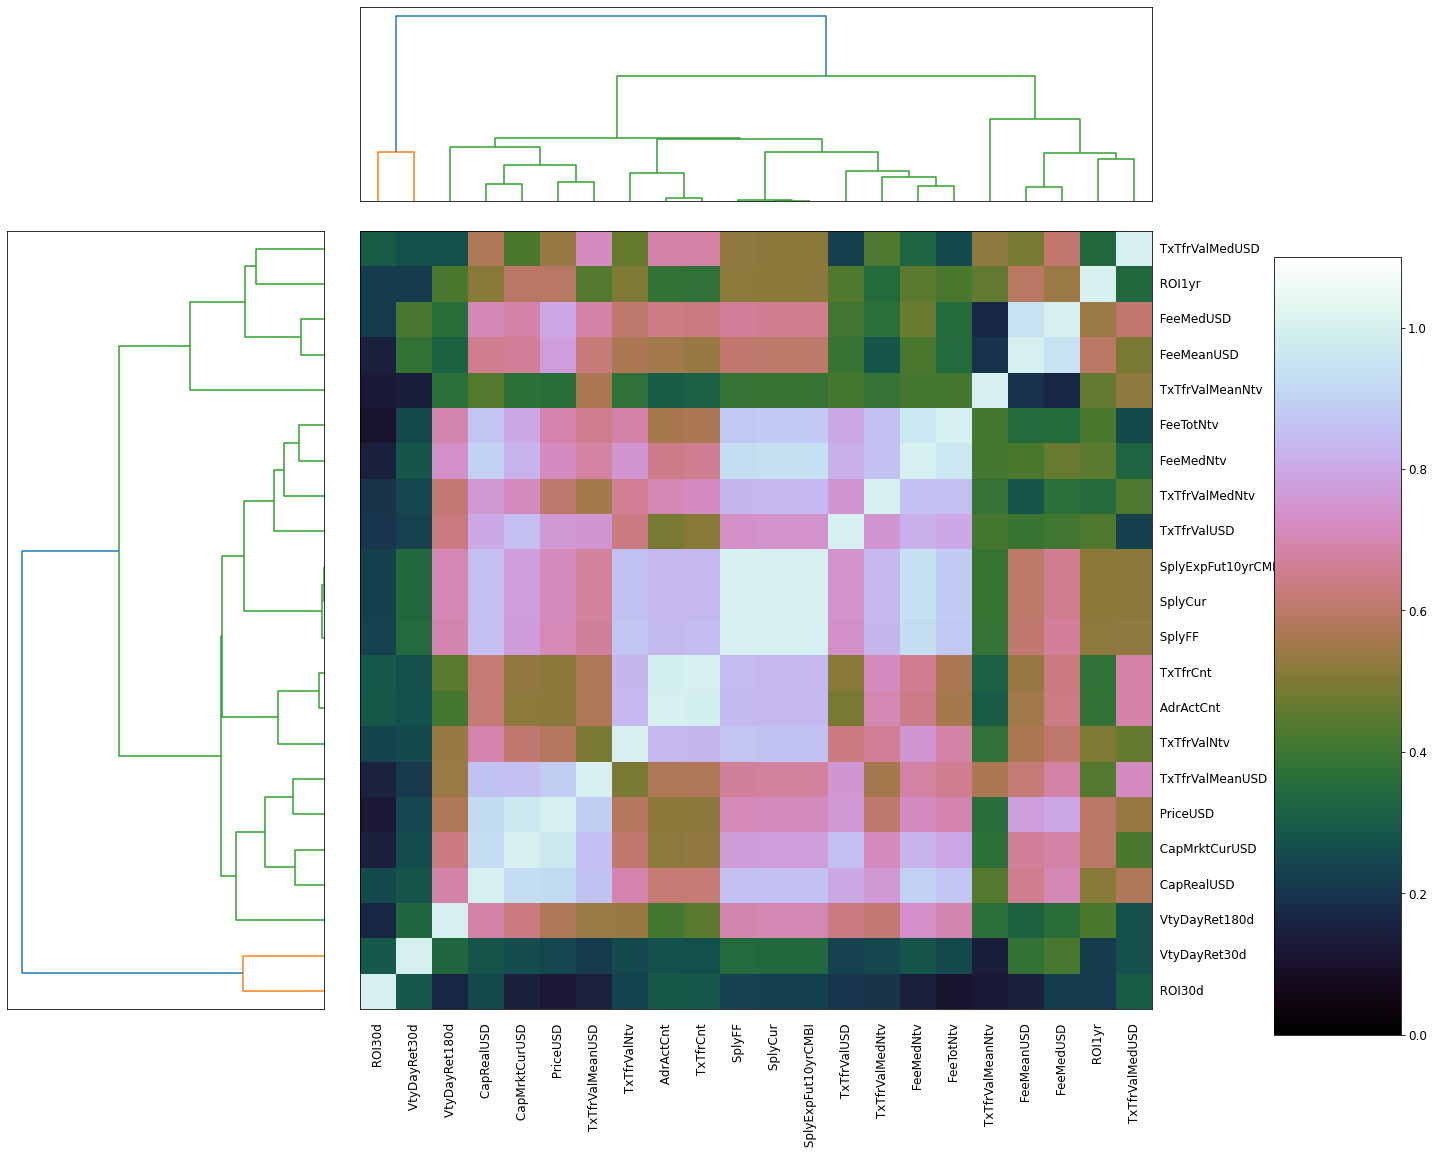

In [61]:
from biokit.viz import heatmap

df_regresion_wo.rename(index=str, columns={"Gross pay transform": "Gross pay tr"}, inplace=True)
distcorr = lambda column1, column2: dcor.distance_correlation(column1, column2)
rslt = df_regresion_wo.apply(lambda col1: df_regresion_wo.apply(lambda col2: distcorr(col1, col2)))
h = heatmap.Heatmap(rslt)
h.plot(vmin=0.0, vmax=1.1, cmap='cubehelix')
fig = plt.gcf()
fig.set_size_inches(22, 18)
plt.gcf().get_axes()[1].invert_xaxis();
plt.savefig('BTC_dendograma.png', dpi = 100)